In [5]:

from PIL import Image
import numpy as np
import cv2
import time
import sys

%run "common_functions.py"

sys.setrecursionlimit(53000) # override needed for computing midpoints, which uses a recursive function
Image.MAX_IMAGE_PIXELS = 366498276 # override is needed, or else it gives a DecompressionBombError

cy1_shifted_file = "originals/shiftedcycle 1thnksgv.tif"
cy2_shifted_file = "originals/shiftedcycle 2thnksgv.tif"

def c(img):
    return Image.fromarray(img)

def overlay(arr1, arr2):
    return (arr1 / 3 + arr2 / 2);

In [14]:



def alignImages(im1, im2):
  # Convert images to grayscale
  #im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  #im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
 
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(10000)
  keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
 
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = list(matcher.match(descriptors1, descriptors2, None))
 
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
  print("Count of Matches:", len(matches))
  numGoodMatches = int(len(matches) * .01)
  print("Count of Good Matches:", numGoodMatches)
  print("Distance of worst match:", matches[numGoodMatches].distance)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  #imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  #cv2.imwrite("matches.jpg", imMatches)
 
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
 
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
  # Use homography
  height, width = np.array(im2.shape) * 2
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
  
  # now, find and print the x y shift that the center experiences... 
  disp = np.dot(hello, [250,250, 1])
  print(disp[0:1] * disp[2])
  
  
 
  return im1Reg, h
 


In [7]:
layer_to_align = 2

img_cy1 = Image.open(cy1_shifted_file)
brightfield_cy1 = np.array(img_cy1)
brightfield_cy1 = (brightfield_cy1/256).astype('uint8') # don't need the whole range of values, so this reduces mem size, + improves access speed

img_cy2 = Image.open(cy2_shifted_file)
brightfield_cy2 = np.array(img_cy2)
brightfield_cy2 = (brightfield_cy2/256).astype('uint8') 

img_cy1 = None
img_cy2 = None

brightfield_cy1[brightfield_cy2 == 0] = 0
brightfield_cy2[brightfield_cy1 == 0] = 0

print(brightfield_cy1.shape)
brightfield_cy1 = brightfield_cy1[10000:12000, 10000:12000]
brightfield_cy2 = brightfield_cy2[10000:12000, 10000:12000]
print(brightfield_cy1.shape)

(15640, 15640)
(2000, 2000)


In [ ]:
#### inital shift

block_points = blockify(4) * brightfield_cy1.shape[0]
girth = int(block_points[0][0][0])

avg_disp = []

n = -3
for i in block_points:
    for j in i:
        if n == 1:
            break
        n += 1
        x,y = j.astype(int)
        alngd, h, xydisp = (alignImages(brightfield_cy1[y-girth:y+girth, x- girth:x+girth,], brightfield_cy2[y-girth:y+girth, x- girth:x+girth,]))
        avg_disp.append(xydisp)

750 1250
250
(500, 1500) (1000, 1000)
Count of Matches: 7584
Count of Good Matches: 75
Distance of worst match: 63.0
[[ 9.95301583e-01 -1.23420210e-03  2.67263170e+01]
 [ 2.42526241e-03  9.93197698e-01  4.25621361e+01]
 [-7.40569103e-06 -5.15807847e-06  1.00000000e+00]]
250 250
Count of Matches: 7566
Count of Good Matches: 75
Distance of worst match: 60.0
[[ 1.00931461e+00 -1.01741412e-02  2.53065996e+01]
 [ 6.25668654e-03  1.00219058e+00  4.10627104e+01]
 [ 1.50998684e-05 -8.74635178e-06  1.00000000e+00]]
250 750
Count of Matches: 7563
Count of Good Matches: 75
Distance of worst match: 54.0
[[ 1.00960816e+00  5.17232639e-03  1.96036927e+01]
 [ 3.07288583e-03  1.02539992e+00  3.93242554e+01]
 [-3.26522416e-06  4.05042153e-05  1.00000000e+00]]
250 1250
Count of Matches: 7600
Count of Good Matches: 76
Distance of worst match: 61.0
[[ 1.00472672e+00 -5.35690078e-03  1.97549756e+01]
 [ 2.85437377e-03  1.00080923e+00  4.23745772e+01]
 [ 8.59136299e-06 -3.80020661e-06  1.00000000e+00]]
250 1

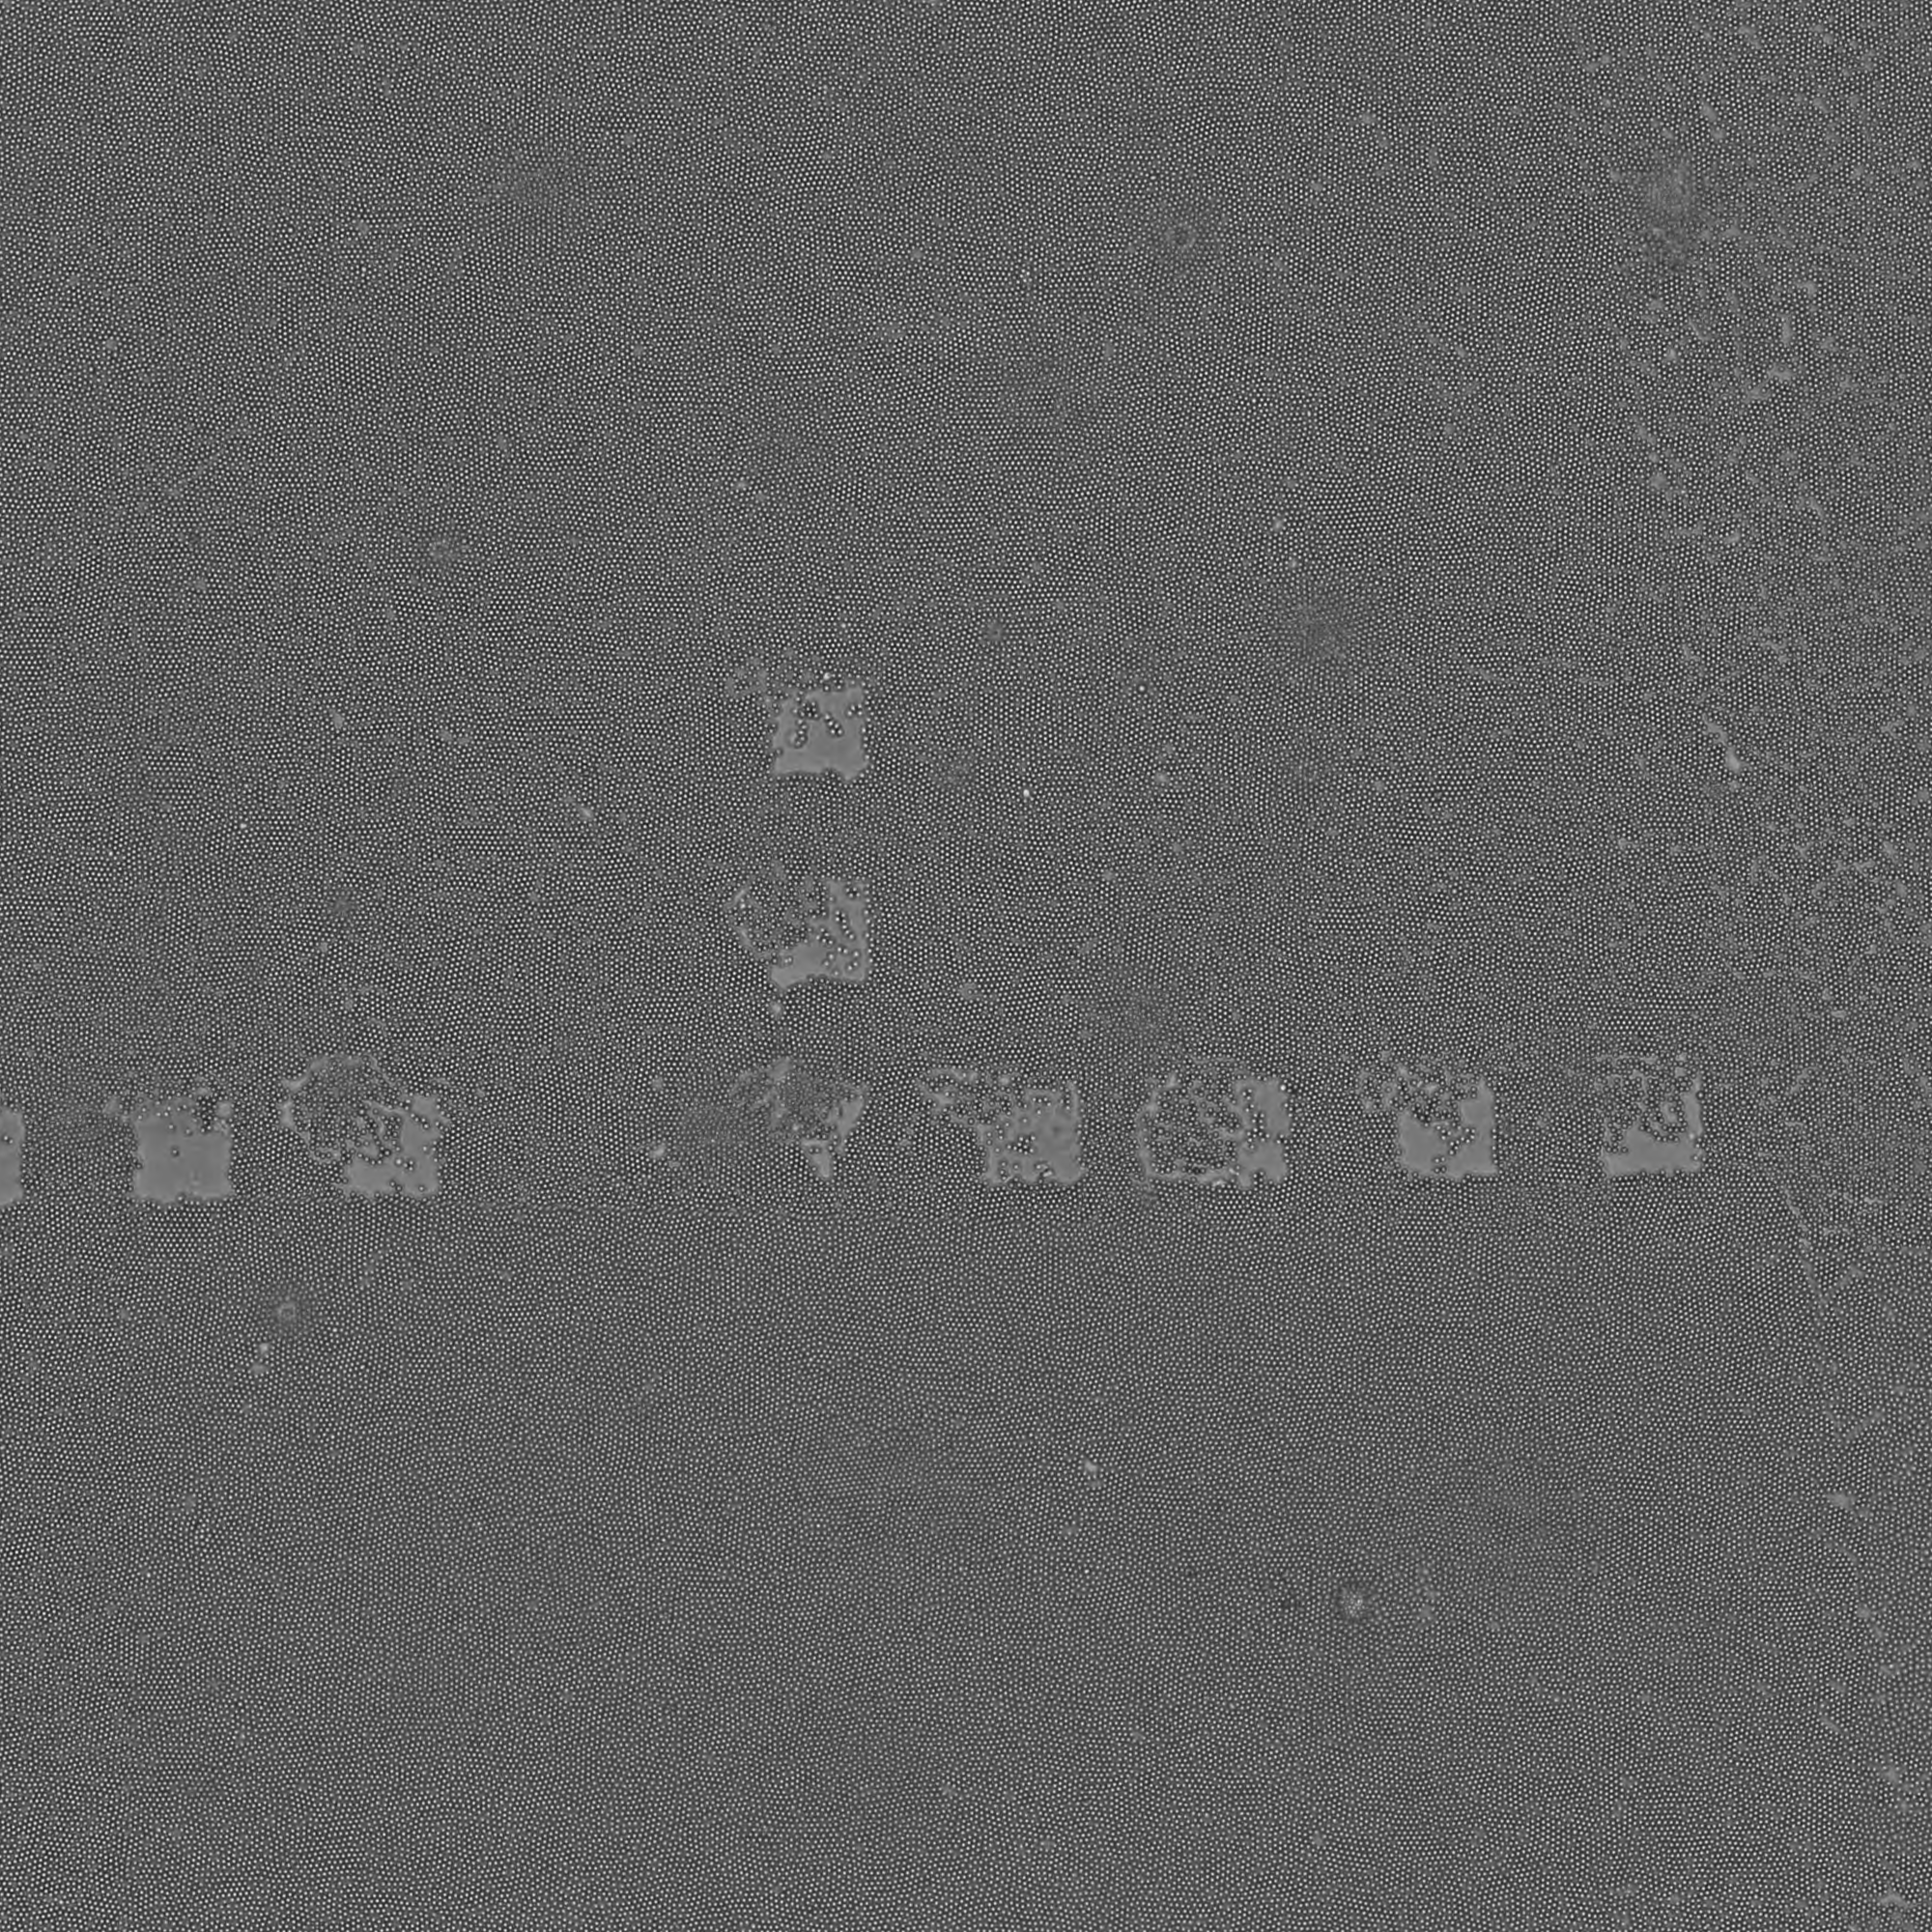

In [13]:
def blockify(cuts):
    
    # Returns the center points of all the blocks in a cuts x cuts array
    
    centerpoints = []
    for i in range(cuts):
        row = []
        for j in range(cuts):
            # print((i + 1), cuts, (j + 1), cuts)
            row.append(np.array([(2*i + 1) / (cuts *2), (2*j + 1) / (cuts *2)]))
            # print((2*i + 1) / (cuts *2))
        
        centerpoints.append(np.array(row))
            
    return np.array(centerpoints)


# https://factorization.info/factors/1/factors-of-17472.html 
# the second param as below can be
block_points = blockify(4) * brightfield_cy1.shape[0]
width = brightfield_cy1.shape[0] / 32 / 2
# print( block_points )
lol = brightfield_cy2.copy()
for i in block_points:
    for j in i:
        # print(j)
        j = j.astype(int)
        
        lol = cv2.circle(lol, j.astype(int), 10, 255, 10)
        x,y = j
        girth = int(block_points[1][1][0])
        cv2.rectangle(lol, (x-girth, y+girth), (x+girth, y-girth), (255, 255, 255), 2) 
        # print((x-girth, y-girth), (x+girth, y+girth))
  

x,y = block_points[1][2].astype(int)
print(x,y)
girth = int(block_points[0][0][0])
print(girth)
# print(x - girth, x+girth, y-girth, y+girth )    
# print(slice(x-girth, y+girth), slice(x-girth, y+girth))
cv2.rectangle(lol, (x-girth, y+girth), (x+girth, y-girth), (255, 255, 255), 102) 
print((x-girth, y+girth), (x+girth, y-girth))
c(lol)
# LETS GOOOOOOO FIGURED IT OUUUTTTTT!!
c(brightfield_cy1[y-girth:y+girth, x- girth:x+girth,])

n = -222
new_crew = c(np.zeros((2000,2000))).convert("RGBA")

for i in block_points:
    for j in i:
        if n == 1:
            break
        n += 1
        x,y = j.astype(int)
        alngd, h = (alignImages(brightfield_cy1[y-girth:y+girth, x- girth:x+girth,], brightfield_cy2[y-girth:y+girth, x- girth:x+girth,]))
        arr = np.array((c(alngd)).convert("RGBA"))
        arr[:, :, 3] = (255 * (arr[:, :, :3] != 0).any(axis=2)).astype(np.uint8)
        print(x, y )
        
        new_crew.paste(c(arr),(x-girth, y-girth), c(arr))

        # new_crew[y-girth:y+girth, x- girth:x+girth,] = alngd

# new_crew
# c(brightfield_cy2)


ValueError: Could not save to JPEG for display

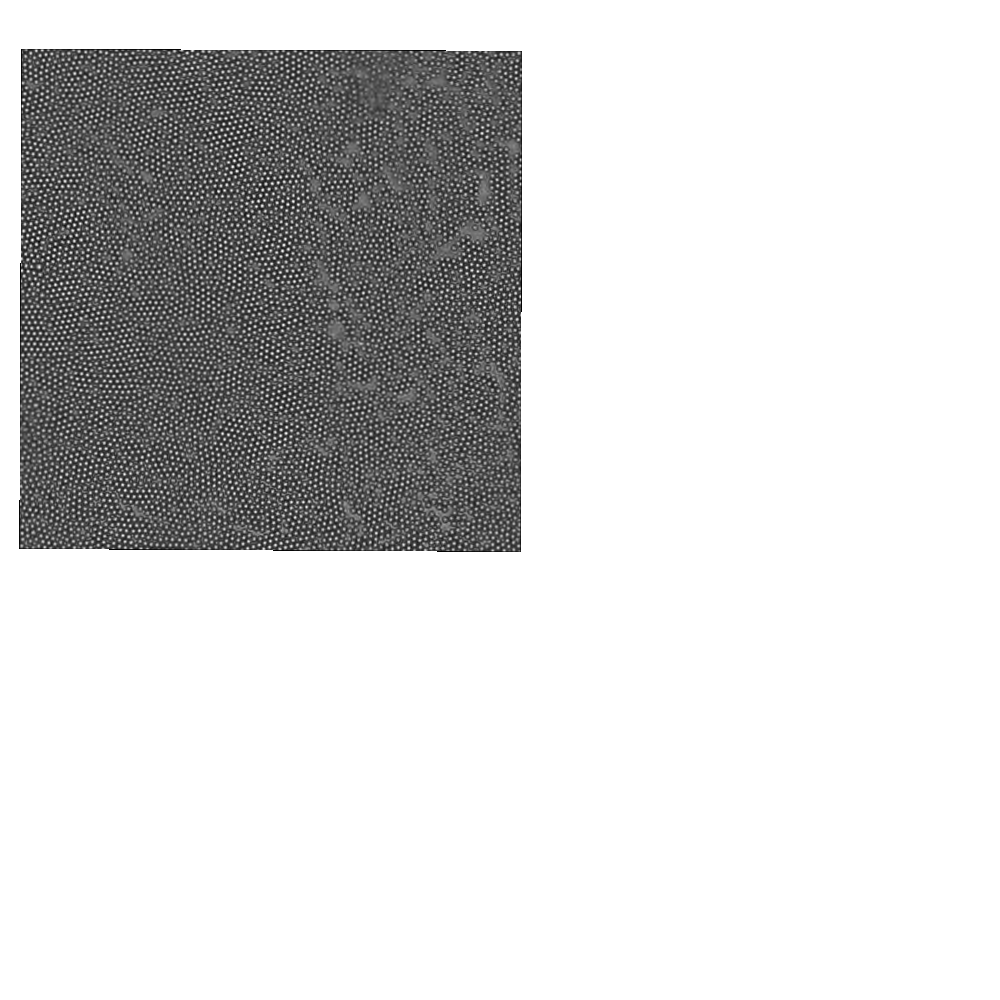

In [ ]:

block_n = 1
start_offset = 3000 # otherwise the first few bites will be 100% black.
chunking = 500
boundary = 75
boundary = (boundary + (boundary % 2)) / 2 # ensures evenesss

alignable_start = start_offset + (chunking * (block_n - 1))
alignable_end = start_offset + (chunking * (block_n))
bounded_start = int(start_offset + (chunking * (block_n - 1)) - boundary)
bounded_end = int(start_offset + (chunking * (block_n)) + boundary)

# print(alignable_start, alignable_end)
# print(bounded_start, bounded_end)

bf_cy1_1_1 = brightfield_cy1[alignable_start:alignable_end, alignable_start:alignable_end].copy() # x, y
bf_cy2_1_1 = brightfield_cy2[bounded_start:bounded_end, bounded_start:bounded_end].copy() # x, y

### override
bf_cy1_1_1 = brightfield_cy1[10000:10500, 10000:10500].copy() # x, y
bf_cy2_1_1 = brightfield_cy2[10000:10500, 10000:10500].copy() # x, y

# bf_cy1_1_1 = brightfield_cy1[10000:11000, 10000:10500].copy() # x, y
# bf_cy2_1_1 = brightfield_cy2[10450:11050, 9950:10550].copy() # x, y


# bf_cy1_1_1 = np.pad(bf_cy1_1_1, (50,50), 'constant')

print(bf_cy1_1_1.shape, bf_cy2_1_1.shape)
# c(bf_cy1_1_1)
# bf_cy1_1_1 = brightfield_cy1[2000:4000, 0:2000].copy() # x, y
# bf_cy2_1_1 = brightfield_cy2[1950:4050, 0:2100].copy() # x, y

# print(bf_cy1_1_1.shape, bf_cy2_1_1.shape)

(0, 0) (0, 0)
